# Radon example from Gelman and Hill (2006)
This is a reworking of the radon example from pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html


Other implementations in: 

- tensorflow https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer - pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html 

- stan https://mc-stan.org/users/documentation/case-studies/radon.html 

- pyro https://github.com/pyro-ppl/pyro-models/blob/master/pyro_models/arm/radon.py 

- numpyro fibrosis dataset http://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html

In [1]:
import altair as alt
try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass
from bayes_window import BayesWindow
from bayes_window.utils import load_radon
df = load_radon()

df

,county,radon,floor
0,AITKIN,2.2,1
1,AITKIN,2.2,0
2,AITKIN,2.9,0
3,AITKIN,1.0,0
4,ANOKA,3.1,0
...,...,...,...
922,WRIGHT,6.4,0
923,WRIGHT,4.5,0
924,WRIGHT,5.0,0
925,YELLOW MEDICINE,3.7,0


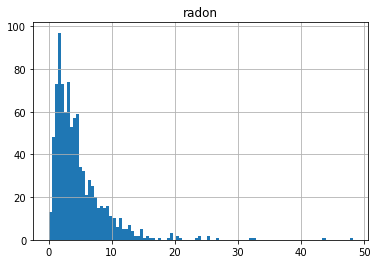

In [2]:
df.set_index(['county','floor']).hist(bins=100);

In [3]:
window=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')

## Plot data

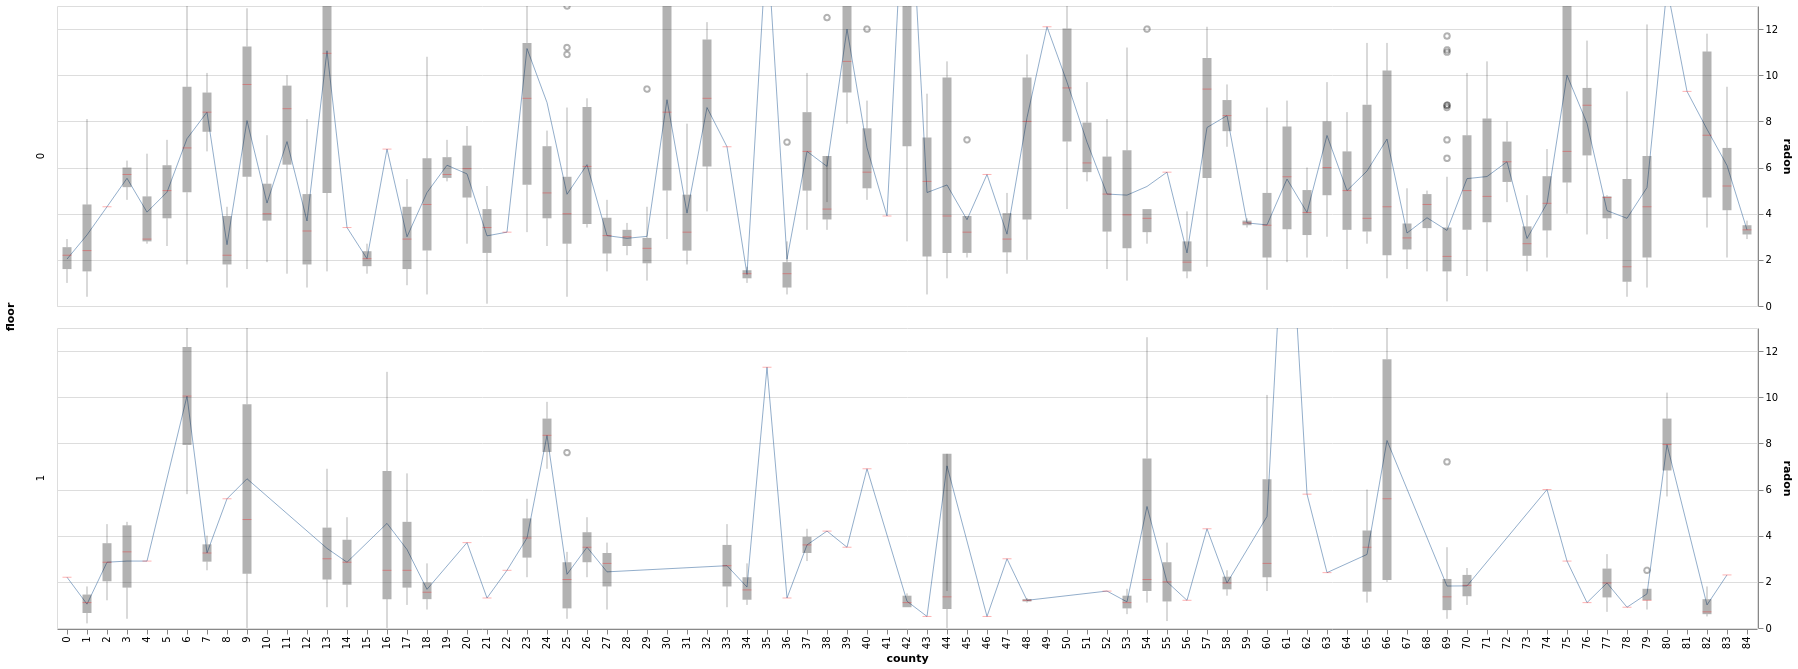

In [4]:
window.plot(x='county').facet(row='floor')

## Fit LME

Using formula radon ~  C(floor, Treatment) + (1 | county)
                           Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept                  5.493    0.525  10.464  0.000   4.464   6.522
C(floor, Treatment)[T.1]  -2.289    0.388  -5.899  0.000  -3.050  -1.529
1 | county                 0.005    0.011   0.450  0.653  -0.016   0.025
Group Var                  2.852    0.207                               


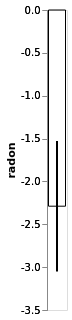

In [5]:
window.fit_lme()#formula='radon ~ floor + ( 1 | county)')

window.plot()

## Fit Bayesian hierarchical with and without county-specific intercept

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(255, 180)


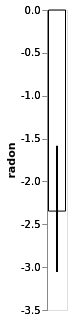

In [6]:
window1=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window1.fit_slopes(add_group_intercept=True);
window1.plot()

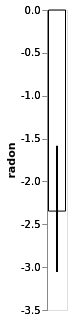

In [7]:
window1.plot(x=':O')

### Inspect intercepts (horizontal ticks)

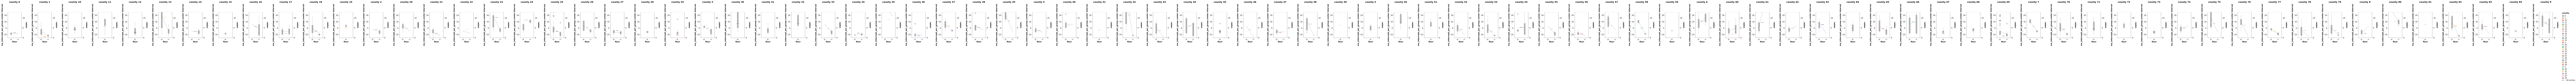

In [8]:
window1.plot_intercepts()

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(255, 180)


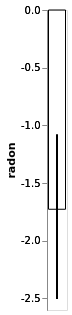

In [9]:
window2=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window2.fit_slopes(add_group_intercept=False, add_group_slope=False, do_make_change='subtract');
window2.plot()

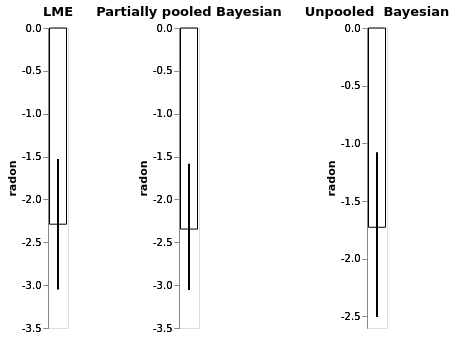

In [10]:
(window.plot().properties(title='LME')|
 window1.plot().properties(title='Partially pooled Bayesian')|
 window2.plot().properties(title='Unpooled  Bayesian'))

## Compare the two models

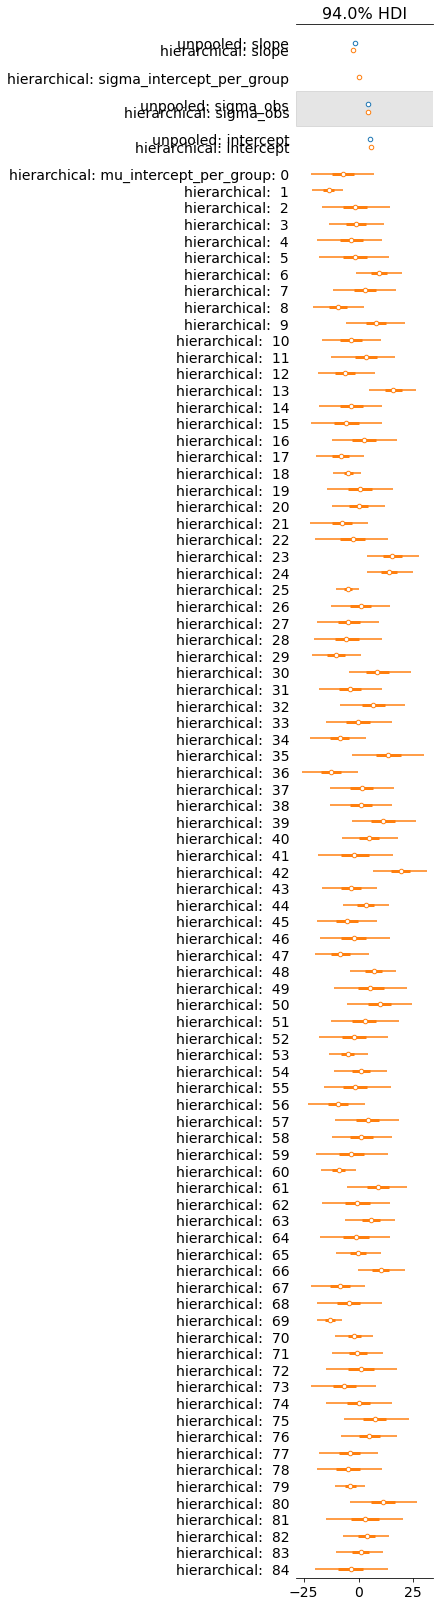

In [11]:
import arviz as az
datasets = {'unpooled' : window2.trace.posterior,
           'hierarchical': window1.trace.posterior} 

az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), 
               #backend='bokeh',
               #kind='ridgeplot',
               #ridgeplot_overlap=1.6,
               combined=True);



For leave-one-out, let's remove any counties that did not contain both floors. This drops about 250 rows

In [12]:
import pandas as pd
df_clean = pd.concat([ddf for i, ddf in df.groupby(['county']) 
                      if (ddf.floor.unique().size>1) 
                      and (ddf[ddf['floor']==0].shape[0]>1)
                      and (ddf[ddf['floor']==1].shape[0]>1)
                     ])


df_clean

,county,radon,floor
4,ANOKA,3.1,0
5,ANOKA,2.5,0
6,ANOKA,1.5,0
7,ANOKA,1.0,0
8,ANOKA,0.7,0
...,...,...,...
907,WINONA,10.2,0
908,WINONA,11.3,0
909,WINONA,7.6,0
910,WINONA,11.8,0


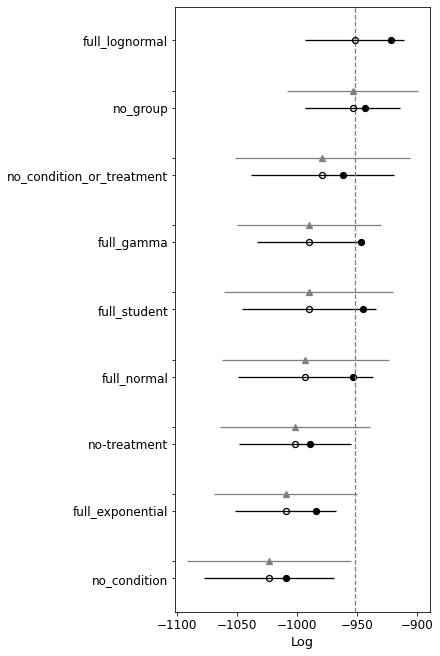

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full_lognormal,0,-951.944282,30.688782,0.000000,4.738574e-01,41.137103,0.000000,True,log
no_group,1,-953.669425,10.285519,1.725142,3.271568e-01,39.470815,54.733428,False,log
no_condition_or_treatment,2,-978.731164,17.189386,26.786881,8.615790e-02,59.515258,73.201990,True,log
full_gamma,3,-989.812237,43.321821,37.867955,6.261808e-11,43.299467,60.167571,True,log
full_student,4,-990.088058,45.477601,38.143775,6.840738e-02,56.033160,70.519405,True,log
full_normal,5,-992.913469,39.320053,40.969187,4.442043e-02,55.929727,69.943942,True,log
no-treatment,6,-1001.549111,12.226121,49.604829,3.349875e-11,46.421574,62.639994,True,log
full_exponential,7,-1009.445091,25.079618,57.500809,9.875576e-12,42.085471,59.298932,True,log
no_condition,8,-1023.517350,14.329721,71.573068,0.000000e+00,54.123402,68.205083,True,log


In [13]:
window1.data=df_clean
window1.explore_models()

It looks like using including intercept actually hurts leave-one-out posterior predictive. Actually, so does including floor in the model. To bring this home, let's only use the models that did not have a warning above:

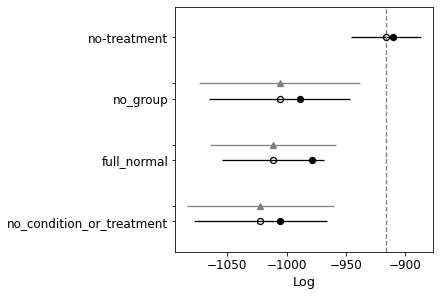

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
no-treatment,0,-916.133463,6.159787,0.000000,0.734468,29.920250,0.000000,False,log
no_group,1,-1006.065825,17.576543,89.932363,0.260559,59.802566,67.795037,True,log
full_normal,2,-1011.472675,32.858776,95.339212,0.004973,43.138084,52.967461,True,log
no_condition_or_treatment,3,-1022.207173,16.297596,106.073710,0.000000,55.829260,61.943095,True,log


In [14]:
from bayes_window.model_comparison import compare_models

compare_models(df_clean,y=window1.y,parallel=True,
    models = {
                'full_normal': window1.model,
                'no_condition_or_treatment': window1.model,
                'no-treatment': window1.model,
                'no_group': window1.model,
            },
            extra_model_args = [
                {'treatment': window1.treatment, 'group': window1.group},
                {'treatment': None, 'condition': None},
                {'treatment': None, 'condition': window1.condition},
                {'treatment': window1.treatment, 'group': None},
            ])

Keep in mind though that we had to remove some data that had too few labels in order to make LOO work. 

## References

  -  Gelman, A., & Hill, J. (2006), Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.), Cambridge University Press.
  -  Gelman, A. (2006), Multilevel (Hierarchical) modeling: what it can and cannot do, Technometrics, 48(3), 432–435.
  -  McElreath, R. (2020), Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.), CRC Press.

